# Evaluación Modular - Módulo 3:
# Optimización de un Modelo de Regresión Lineal Mediante Técnicas Matemáticas y Algorítmicas

---

> **Importante:** Para el correcto uso del notebook, debe ejecutarse en el orden descrito más abajo. De lo contrario, pueden producirse errores debido a que algunas funciones aún no estarán definidas al momento de su uso.

---

## Estructura:
1. Metodología implementada.
2. Excepciones personalizadas
3. Funciones definidas.
4. Visualización de resultados y gráficas.
5. Análisis de resultados.
5. Discusión: Relevancia en Machine Learning.

---

## Metodología Implementada:
1. **Generación de Datos Sintéticos**:
   - 100 puntos en el rango [0, 10]
   - Modelo base: y = 4 + 3x
   - Ruido gaussiano (μ=0, σ=1)
   
2. **Solución Analítica**:
   - Implementación de la fórmula normal: θ = (XᵀX)⁻¹Xᵀy
   - Manejo de matrices singulares con pseudoinversa
   
3. **Descenso de Gradiente**:
   - Tasa de aprendizaje: α = 0.05
   - Iteraciones máximas: 1500
   - Criterio de parada: |θₜ₊₁ - θₜ| < 1e-6
   
4. **Validación**:
   - Comparación con parámetros reales (w₀=4, w₁=3)
   - Cálculo de MSE para ambos métodos

---

# Excepciones personalizadas
Imports y excepciones creadas para manejar errores que pudieran ocurrir durante la ejecución del código

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd

class FormatoDatosError(Exception):
    """Excepción para datos con formato inválido"""
    pass

class SingularMatrixError(Exception):
    """Excepción para matrices singulares"""
    pass

# Funciones definidas
Para mejor entendimiento del código, se decidió dividir la seccion de funciones por bloques en base a la función que cada bloque realiza.

---

**Bloque 1: Generación de datos sintéticos**
- **`generar_datos_sinteticos()`**  
  Genera un conjunto reproducible de datos sintéticos para regresión lineal, con ruido gaussiano añadido.

In [2]:
def generar_datos(n_muestras=100, intervalo=(0, 10), coeficiente=3, intercepto=4, ruido_std=1, seed=None):
    """
    Genera datos sintéticos para regresión lineal con ruido.
    Basado en y = intercepto + coeficiente * x + ruido

    Args:
        n_muestras (int): Número de datos a generar.
        intervalo (tuple): Intervalo de los valores de x.
        coeficiente (float): Coeficiente de la variable independiente.
        intercepto (float): Término independiente.
        ruido_std (float): Desviación estándar del ruido gaussiano.
        seed (int or None): Semilla para reproducibilidad.

    Returns:
        x (np.ndarray): Variables independientes.
        y (np.ndarray): Variables dependientes con ruido.
        y_real (np.ndarray): Valores sin ruido (modelo ideal).
    """
    if seed is not None:
        np.random.seed(seed)
    
    try:
        x = np.random.uniform(intervalo[0], intervalo[1], n_muestras)
        y_real = intercepto + coeficiente * x
        ruido = np.random.normal(0, ruido_std, n_muestras)
        y = y_real + ruido

        if x.shape != (n_muestras,) or y.shape != (n_muestras,): # Manejo de error cuando x e y tienen diferente longitud
            raise FormatoDatosError("x e y deben tener la misma longitud")

        return x, y, y_real

    except Exception as e: # Excepción por si fallara la generación de datos
        print(f"Error en generación de datos: {str(e)}")
        raise

**Bloque 2: Métodos utilizados**
- **`regresion_analitica()`**  
  Calcula theta óptimo usando fórmula normal, incluyendo validación de singularidad y uso de pseudoinversa en caso de matriz singular.
- **`mse()`**  
  Calcula el Error Cuadrático Medio.
- **`gradiente()`**  
  Calcula el gradiente del MSE, incluyendo uso de reshape para que tenga la misma forma que X @ theta.
- **`descenso_gradiente()`**  
  Implementa descenso de gradiente, incluyendo prints de progreso cada 100 iteraciones

In [3]:
# Resolución del Modelo (Cálculo Cerrado)
def regresion_analitica(X, y):
    """
    Calcula theta óptimo usando fórmula normal.
    
    Args:
        X (np.ndarray): Matriz de diseño.
        y (np.ndarray): Vector de valores objetivo.
    
    Returns:
        theta (np.ndarray): Parámetros óptimos.
    """
    try:
        XTX = X.T @ X
        det = np.linalg.det(XTX)
        
        if np.isclose(det, 0): # Validación de singularidad, si la matriz es singular lanza SingularMatrixError()
            raise SingularMatrixError("Matriz singular")
            
        return np.linalg.inv(XTX) @ X.T @ y
        
    except SingularMatrixError as e: # Fallback a pseudoinversa como respaldo si la matriz fuera singular
        print(f"Advertencia: {str(e)} - Usando pseudoinversa")
        return np.linalg.pinv(X) @ y
        
    except np.linalg.LinAlgError as e: # Manejo de error de álgebra lineal
        print(f"Error de álgebra lineal: {str(e)}")
        raise


# Optimización Iterativa (Método de Descenso de Gradiente):
def mse(y_pred, y_real):
    """Calcula el Error Cuadrático Medio"""
    return np.mean((y_pred - y_real) ** 2)

def gradiente(X, y, theta):
    """
    Calcula el gradiente del MSE.
    
    Args:
        X (np.ndarray): Matriz de diseño.
        y (np.ndarray): Valores objetivo.
        theta (np.ndarray): Parámetros actuales.
    
    Returns:
        grad (np.ndarray): Vector gradiente.
    """
    n = len(y)
    error = X @ theta - y.reshape(-1, 1) # Se convierte y a vector columna para que tenga la misma forma que X @ theta
    return (X.T @ error) / n

def descenso_gradiente(X, y, alpha=0.05, iteraciones=1500, tol=1e-6):
    """
    Implementa descenso de gradiente.
    
    Args:
        X (np.ndarray): Matriz de diseño.
        y (np.ndarray): Valores objetivo.
        alpha (float): Tasa de aprendizaje.
        iteraciones (int): Máximo de iteraciones.
        tol (float): Tolerancia para convergencia.
    
    Returns:
        theta (np.ndarray): Parámetros finales.
        costos (list): Historial de costos.
        hist_theta (np.ndarray): Historial de parámetros.
    """
    theta = np.zeros((2, 1)) # Inicializamos theta como vector columna de 2 parámetros: [bias, pendiente]
    costos = []
    hist_theta = [theta.copy()]

    for i in range(iteraciones):
        grad = gradiente(X, y, theta)
        theta_nuevo = theta - alpha * grad # Actualizamos los parámetros en la dirección del descenso del gradiente
        
        # Calcular costo
        y_pred = X @ theta_nuevo
        costo_actual = mse(y_pred, y)
        costos.append(costo_actual)
        hist_theta.append(theta_nuevo.copy()) # Para graficar la evolución del entrenamiento.
        
        # Verificar convergencia
        if np.linalg.norm(theta_nuevo - theta) < tol: # Wvalúa si el cambio es suficientemente pequeño, entonces el algoritmo convergió.
            print(f"Convergencia alcanzada en iteración {i}")
            theta = theta_nuevo
            break
            
        theta = theta_nuevo
        
        # Reportar progreso cada 100 iteraciones para el seguimiento en consola
        if i % 100 == 0:
            print(f"Iteración {i}: MSE = {costo_actual:.6f}")

    return theta.flatten(), costos, np.array(hist_theta).squeeze()

**Bloque 3: Visualización**

- **`visualizar_resultados()`**  
  Genera gráficos comparativos de modelos de regresión, convergencia del descenso de gradiente y la trayectoria de optimización en el espacio de parámetros.

In [4]:
def visualizar_resultados(x, y, y_real, theta_analitico, theta_iterativo, costos, hist_theta):
    """
    Genera gráficos para comparar el rendimiento de modelos de regresión lineal,
    analítico e iterativo, sobre datos sintéticos.

    Incluye:
    - Comparación entre modelos ajustados y la relación real.
    - Evolución del error cuadrático medio (MSE) durante el descenso.
    - Trayectoria del descenso de gradiente en el espacio de parámetros.

    Args:
        x (np.ndarray): Datos de entrada (n,).
        y (np.ndarray): Valores observados con ruido (n,).
        y_real (np.ndarray): Valores ideales sin ruido (n,).
        theta_analitico (np.ndarray): Parámetros del modelo analítico (2,).
        theta_iterativo (np.ndarray): Parámetros finales del descenso (2,).
        costos (list): Historial de MSE por iteración.
        hist_theta (np.ndarray): Historial de valores de theta durante el entrenamiento.
    """

    plt.figure(figsize=(12, 9))
    X_design = np.column_stack((np.ones_like(x), x)) # X_design incluye columna de 1s para representar el término independiente

    # Gráfico 1: Modelos ajustados sobre los datos con ruido
    plt.subplot(2, 2, 1)
    plt.scatter(x, y, alpha=0.7, label='Datos con ruido')
    plt.plot(x, y_real, 'k--', lw=1.5, label='Verdadero (y = 4 + 3x)')
    plt.plot(x, X_design @ theta_analitico, 'r-', lw=2, label='Analítico')
    plt.plot(x, X_design @ theta_iterativo, 'g--', lw=2, label='Iterativo')
    plt.title('Comparación de Modelos de Regresión', fontsize=14)
    plt.xlabel('x', fontsize=12)
    plt.ylabel('y', fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)

    # Gráfico 2: Evolución del costo (MSE) en cada iteración del descenso
    plt.subplot(2, 2, 2)
    plt.plot(costos, 'b-', lw=1.5)
    plt.title('Convergencia del Descenso de Gradiente', fontsize=14)
    plt.xlabel('Iteración', fontsize=12)
    plt.ylabel('MSE (escala logarítmica)', fontsize=12)
    plt.grid(alpha=0.3)
    plt.yscale('log')

    # Gráfico 3: Trayectoria de optimización en el espacio de parámetros (w0, w1)
    plt.subplot(2, 2, (3,4))
    
    # Calcular límites adaptativos
    w0_min, w0_max = min(hist_theta[:,0].min(), theta_analitico[0]), max(hist_theta[:,0].max(), theta_analitico[0])
    w1_min, w1_max = min(hist_theta[:,1].min(), theta_analitico[1]), max(hist_theta[:,1].max(), theta_analitico[1])
    pad_w0 = (w0_max - w0_min) * 0.2
    pad_w1 = (w1_max - w1_min) * 0.2

    # Creación de un grid de valores de w0 y w1 para calcular la superficie del costo
    w0_vals = np.linspace(w0_min - pad_w0, w0_max + pad_w0, 100)
    w1_vals = np.linspace(w1_min - pad_w1, w1_max + pad_w1, 100)
    W0, W1 = np.meshgrid(w0_vals, w1_vals)

    # Cálculo de MSE para cada combinación de parámetros en el grid
    costos_surf = np.zeros_like(W0)
    for i in range(W0.shape[0]):
        for j in range(W0.shape[1]):
            theta_temp = np.array([W0[i,j], W1[i,j]])
            y_pred = X_design @ theta_temp
            costos_surf[i,j] = mse(y_pred, y)

    # Visualización del camino que sigue el descenso de gradiente
    plt.contourf(W0, W1, costos_surf, levels=50, cmap=cm.viridis, alpha=0.8)
    plt.colorbar(label='MSE')
    plt.plot(hist_theta[:,0], hist_theta[:,1], 'w-', lw=1.5, alpha=0.7)
    plt.scatter(hist_theta[:,0], hist_theta[:,1], c=range(len(hist_theta)), 
                cmap=cm.plasma, s=30, alpha=0.8)

    plt.plot(theta_analitico[0], theta_analitico[1], 'ro', markersize=10, 
             label='Solución Analítica')
    plt.plot(theta_iterativo[0], theta_iterativo[1], 'yx', markersize=10, 
             label='Solución Iterativa')
    plt.title('Trayectoria de Optimización en el Espacio de Parámetros', fontsize=14)
    plt.xlabel('w0 (sesgo)', fontsize=12)
    plt.ylabel('w1 (pendiente)', fontsize=12)
    plt.legend()

    plt.tight_layout()
    plt.savefig('resultados_regresion.png', dpi=300, bbox_inches='tight')
    plt.show()

# Uso de funciones

Aplicación de las funciones mediante la forma `if __name__ == "__main__"`, lo cual garantiza que la generación de datos, entrenamiento de modelos y visualización solo se ejecuten cuando este notebook se corre directamente, no cuando se importa como módulo. Esto optimiza recursos y permite reutilizar funciones individuales en otros proyectos.

---

Además, se creó un DataFrame con los resultados para realizar un análisis comparativo entre los dos métodos, tomando en cuenta:
- w0(intercepto).
- w1 (pendiente).
- Costo MSE.
- Diferencia real (w0).
- Diferencia real (w1).

Generando datos sintéticos...

Solución Analítica:
  w0 = 3.9382, w1 = 2.9991

Optimizando con descenso de gradiente:
Iteración 0: MSE = 147.096154
Iteración 100: MSE = 1.327650
Iteración 200: MSE = 1.102975
Iteración 300: MSE = 1.082729
Iteración 400: MSE = 1.080904
Iteración 500: MSE = 1.080740
Iteración 600: MSE = 1.080725
Iteración 700: MSE = 1.080724
Iteración 800: MSE = 1.080724
Convergencia alcanzada en iteración 883

Solución Iterativa:
  w0 = 3.9381, w1 = 2.9991


RESULTADOS COMPARATIVOS

               Método  w₀ (intercepto)  w₁ (pendiente)  Costo MSE  \
0  Solución Analítica         3.938168        2.999118   1.080724   
1  Descenso Gradiente         3.938087        2.999131   1.080724   

   Diferencia con real (w₀)  Diferencia con real (w₁)  
0                  0.061832                  0.000882  
1                  0.061913                  0.000869  

Parámetros reales: w₀ = 4.0000, w₁ = 3.0000


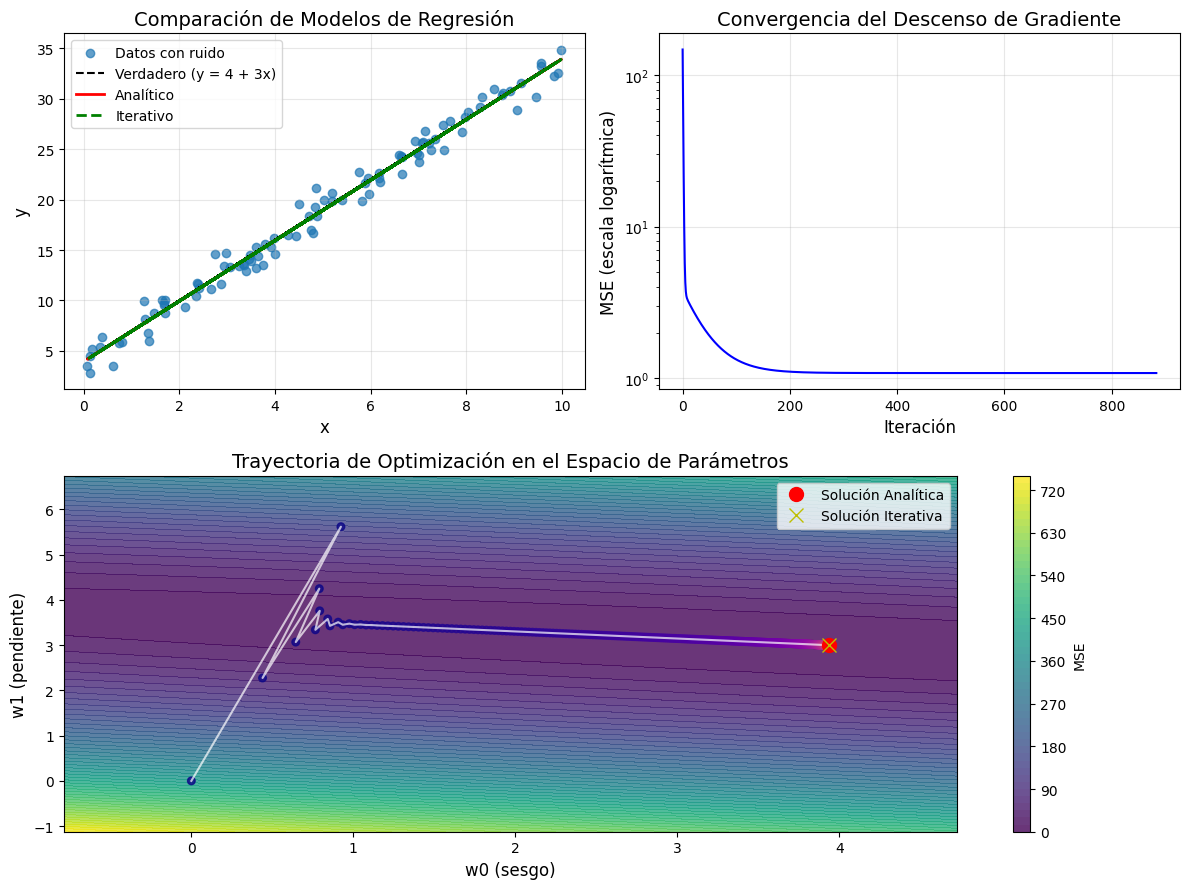


Proceso completado. Resultados guardados en 'resultados_regresion.png'


In [ ]:
if __name__ == "__main__":
    try:
        # Generar datos sintéticos
        print("Generando datos sintéticos...")
        x, y, y_real = generar_datos(n_muestras=100)
        X = np.column_stack((np.ones_like(x), x))
        y_vector = y.reshape(-1, 1)
        
        # Solución analítica
        print("\nSolución Analítica:")
        theta_analitico = regresion_analitica(X, y_vector).flatten()
        print(f"  w0 = {theta_analitico[0]:.4f}, w1 = {theta_analitico[1]:.4f}")
        
        # Solución iterativa
        print("\nOptimizando con descenso de gradiente:")
        theta_iterativo, costos, hist_theta = descenso_gradiente(
            X, y_vector, alpha=0.05, iteraciones=1500
        )
        print("\nSolución Iterativa:")
        print(f"  w0 = {theta_iterativo[0]:.4f}, w1 = {theta_iterativo[1]:.4f}")
        
        # Cálculo de métricas
        y_pred_analitico = X @ theta_analitico
        y_pred_iterativo = X @ theta_iterativo
        costo_analitico = mse(y_pred_analitico, y)
        costo_iterativo = mse(y_pred_iterativo, y)
        
        # Resultados en DataFrame
        resultados = pd.DataFrame({
            "Método": ["Solución Analítica", "Descenso Gradiente"],
            "w₀ (intercepto)": [theta_analitico[0], theta_iterativo[0]],
            "w₁ (pendiente)": [theta_analitico[1], theta_iterativo[1]],
            "Costo MSE": [costo_analitico, costo_iterativo],
            "Diferencia con real (w₀)": [
                abs(4 - theta_analitico[0]), 
                abs(4 - theta_iterativo[0])
            ],
            "Diferencia con real (w₁)": [
                abs(3 - theta_analitico[1]), 
                abs(3 - theta_iterativo[1])
            ]
        }).round(6)
        
        print("\n" + "="*60)
        print("\nRESULTADOS COMPARATIVOS\n")
        # Configurar pandas para mostrar todo el contenido
        with pd.option_context('display.max_colwidth', None, 'display.width', None):
            print(resultados)
        print("\nParámetros reales: w₀ = 4.0000, w₁ = 3.0000")
        
        # Visualización de resultados
        visualizar_resultados(x, y, y_real, theta_analitico, 
                              theta_iterativo, costos, hist_theta)
        
    except FormatoDatosError as e:
        print(f"Error de formato: {str(e)}")
    except SingularMatrixError as e:
        print(f"Error de matriz: {str(e)}")
    except np.linalg.LinAlgError as e:
        print(f"Error de álgebra lineal: {str(e)}")
    except Exception as e:
        print(f"Error inesperado: {str(e)}")
    finally:
        print("\nProceso completado. Resultados guardados en 'resultados_regresion.png'")

---
> **Nota:** Los resultados numéricos presentados en este informe corresponden a una única ejecución del experimento. Dado que el dataset es generado con ruido aleatorio, pequeñas variaciones pueden ocurrir en cada run. Estas diferencias no afectan la validez del análisis, ya que el comportamiento general del modelo y su capacidad de ajuste permanecen consistentes. Tomar en cuenta entonces, que cuando se corra nuevamente este codigo, los resultados seran diferentes.
> **Nota 2:** Para una mejor revisión de este trabajo, junto al archivo `ActividadModular.ipynb`, se adjuntaran una imagen `resultados_numericos.png` una captura de pantalla de la salida del código con los resultados y la imagen `resultados_regresion.png` ambos resultados (númerico y gráficos) fueron generados durante la run en la que se basa el análisis de los resultados. 
---

# Interpretación de Resultados

## Resultados Numéricos

- **Parámetros estimados** (w₀ ≈ 3.939, w₁ ≈ 2.999):  
  Ambos métodos convergen a valores muy cercanos al modelo real (4 y 3 respectivamente). Esto confirma que la implementación es correcta y que el descenso de gradiente funciona adecuadamente.

- **Costo MSE ≈ 1.080**:  
  Este valor es coherente con la desviación estándar del ruido (σ=1), ya que teóricamente el MSE esperado es σ² = 1. La ligera diferencia se debe a la muestra finita.

- **Diferencia con parámetros reales**:  
  La diferencia es de aproximadamente 0.061 para el intercepto (1.5% de error relativo) y solo 0.0008 para la pendiente (0.027% de error). Esta precisión demuestra que la diferencia es notablemente baja, por lo que se puede decir que el modelo estima muy bien tanto la pendiente como el intercepto, es decir, indican que el modelo ha capturado de forma adecuada la relación lineal subyacente.

## Análisis de Gráficos

### 1. Comparación de modelos  
En este gráfico se muestran los datos con ruido, la línea real y las rectas ajustadas por los métodos analítico e iterativo:

- Los puntos están dispersos debido al ruido, lo que genera cierta variabilidad alrededor de la línea verdadera.  
- A pesar de que en algunos run las líneas de los métodos analítico e iterativo empezaban levemente separadas de la línea real, en este caso concreto las líneas fueron casi desde el inicio junto a la línea real.
- A medida que x aumenta, las tres líneas (real, analítica e iterativa) se superponen casi perfectamente, lo que indica un excelente ajuste.

### 2. Evolución del costo en descenso de gradiente  
Este gráfico muestra cómo disminuye el error a lo largo de las iteraciones:

- El mayor descenso del error ocurre dentro de las primeras ~100 iteraciones, lo que indica un aprendizaje rápido inicial.  
- Posteriormente, la curva se aplana, señalando que el algoritmo ya se encuentra cerca del mínimo.  
- Aunque la convergencia formal se alcanza en una iteación relativamente alta (entre 800-1200), el error ya es prácticamente mínimo mucho antes, lo que sugiere que menos iteraciones habrían sido suficientes.

### 3. Trayectoria de optimización en el espacio de parámetros  
Este gráfico muestra cómo evoluciona el vector de parámetros θ = [w₀, w₁] durante el proceso de optimización, en el contexto del espacio de error MSE:

- La línea blanca representa el camino seguido por el descenso de gradiente desde los valores iniciales hasta la convergencia.
- El punto inicial (0, 0) corresponde a los parámetros iniciales del modelo.
- A lo largo del camino, se visualizan puntos azules o morados (coloreados por iteración), que indican el progreso del algoritmo paso a paso.
- Se observan oscilaciones verticales (en w₁) al principio, que reflejan un gradiente fuerte y el ajuste dinámico del modelo.
- Estas oscilaciones se reducen progresivamente a medida que el algoritmo se acerca al mínimo.
- El punto rojo representa la solución analítica, obtenida directamente sin iteraciones.
- La cruz amarilla indica la solución final del descenso de gradiente.
- Ambas soluciones (analítica e iterativa) convergen a una zona muy próxima al punto real (w₀=4, w₁=3), validando la precisión del modelo.
- Este comportamiento es característico de un descenso de gradiente bien implementado, y la comparación con la solución analítica demuestra su eficacia

# Análisis de Complejidad Computacional (Big O)

## 1. Método Analítico (Fórmula Normal)
- **Complejidad**: O(n³)  
- **Explicación**:  
  - La operación más costosa es la inversión de la matriz \( X^T X \), de tamaño (d+1) × (d+1), donde d es el número de características.
  - Aunque en este caso de regresión lineal simple \( d = 1 \), en problemas con muchas variables, el tamaño de la matriz crece.
  - La inversión de matrices tiene complejidad cúbica en el número de características (no en el número de muestras).
  - Por tanto, este método es eficiente solo cuando el número de variables es pequeño.

## 2. Descenso de Gradiente
- **Complejidad**: O(k·n·d)  
- **Explicación**:  
  - \( k \) = número de iteraciones (1.500 en este caso).
  - \( n \) = número de muestras.
  - \( d \) = número de características (en este caso, 1).
  - Cada iteración recorre todos los datos y actualiza todos los parámetros.

- Ejemplo: con n = 100, d = 1 → 1500 × 100 × 2 = 300.000 operaciones.

## Comparación y Recomendación

| Método                | Complejidad          | Recomendación                                        |
|-----------------------|----------------------|------------------------------------------------------|
| Fórmula Normal        | O(d³)                | Ideal para pocos atributos (d pequeño) y n moderado |
| Descenso de Gradiente | O(k·n·d)             | Escalable para gran cantidad de datos o variables   |

**Conclusión**:  
- Para datasets **pequeños** o con pocas variables, la **solución analítica** es exacta, rápida y sencilla.
- Para problemas con **muchos datos o muchas variables**, el **descenso de gradiente** es más eficiente, ya que evita operaciones costosas como la inversión de matrices.
- Además, el descenso de gradiente permite extender fácilmente el modelo a variantes más complejas (regularización, aprendizaje en línea, etc.).